# OPTIC algorithm implementation

### Define class of a single object

In [ ]:
class Object:
    def __init__(self, value, processed = False, reachability_distance = np.inf, core_distance = np.inf, distance = 0, cluster_id = -1):
        self.value = value
        self.processed = processed
        self.reachability_distance = reachability_distance # UNDEFINED np.inf
        self.dist = distance
        self.core_distance = core_distance
        self.cluster_id = cluster_id

    def setCoreDistance(self, neighbors, e, MinPts):
        if len(neighbors) >= MinPts:
            ordered_neighbors = sorted(neighbors, key=lambda x: x.dist)
            self.core_distance = ordered_neighbors[MinPts -1].dist
        return 0


![image.png](https://sun9-75.userapi.com/impg/52DYzB-nom5bedYZi2sjaSqQZLuJAawqaz4ozw/T3TMSIYj7i0.jpg?size=360x458&quality=96&sign=24e82010d0ef90d53fc05e95d92e6f5f&type=album)

In [ ]:
ob = Object([2,1])
ob.processed

False

In [ ]:
from scipy.spatial import distance

def culc_euq_dist(a, b):
    return distance.euclidean(a, b)

### Find all neighbours

![image.png](https://sun9-74.userapi.com/impg/wv1eTLipvu2wAjHJph2oEUTlzw303XCJl_lQoA/oLz5-yXgwUY.jpg?size=842x597&quality=96&sign=404f2ae3eb7096654dbc1ebe5c8a5f42&type=album)

In [ ]:
def find_neighbors(Object, e, SetOfObjects):
    neighbors = []
    for i in SetOfObjects:
        distance = culc_euq_dist(Object.value, i.value)
        if e >= distance and distance != 0:
            i.dist = distance
            neighbors.append(i)
    return neighbors

### OrderSeeds is a bag of reachable objects, ordered by their <br> reachability distance from the currently processed object

![image.png](https://sun9-86.userapi.com/impg/fI3vHClQIM3rrIZAXtUhtOhqPbRVP0UVJPKXOA/5QP9vWT9iOM.jpg?size=717x438&quality=96&sign=e4dd0815740f7355e9437b73c57a9bd8&type=album)


In [ ]:
def update_OrderSeeds(OrderSeeds, neighbors, CenterObject):
    c_dist = CenterObject.core_distance
    for Object in neighbors:
        if Object.processed != True:
            new_r_dist = max(c_dist, culc_euq_dist(CenterObject.value, Object.value))
            if Object.reachability_distance == np.inf:
                Object.reachability_distance = new_r_dist
                OrderSeeds.append(Object)
            else:
                if new_r_dist < Object.reachability_distance:
                    Object.reachability_distance = new_r_dist
            OrderSeeds = sorted(OrderSeeds, key=lambda x: x.reachability_distance)
    return OrderSeeds

### ExpandClusterOrder starts new valeey and allocates all the objects that it have

![image.png](https://sun9-64.userapi.com/impg/4vbKAVGg508n6jBoSjwzkOPKvWanB8jTeJN4lw/HI5PxwRPQ-s.jpg?size=712x576&quality=96&sign=0e11ece37f6e1607cdc5cc983535c7aa&type=album)

In [ ]:
def ExpandClusterOrder(SetOfObjects, Object, e, MinPts, Ordered):
    neighbors = find_neighbors(Object, e, SetOfObjects)
    Object.processed = True
    Object.setCoreDistance(neighbors, e, MinPts)
    OrderSeeds = []
    Ordered.append(Object)
    if Object.core_distance != np.inf:
        OrderSeeds = update_OrderSeeds(OrderSeeds, neighbors, Object)
        while len(OrderSeeds) != 0:
            currentObject = OrderSeeds[0]
            OrderSeeds.pop(0)
            neighbors = find_neighbors(currentObject, e, SetOfObjects)
            currentObject.processed = True
            currentObject.setCoreDistance(neighbors, e, MinPts)
            Ordered.append(currentObject)
            if currentObject.core_distance != np.inf:
                OrderSeeds = update_OrderSeeds(OrderSeeds, neighbors, currentObject)

    return Ordered

### OPTICS iterates through all Objects and calls ExpandClusterOrder

![image.png](https://sun9-45.userapi.com/impg/hzumMdDW_gBrCgDM6Jf-w4Ik8eX-X28GaCBXmQ/nnVv7h2GcpE.jpg?size=730x326&quality=96&sign=9f22789f35a4938148c792244983735a&type=album)

In [ ]:
def OPTICS(SetOfObjects, e, MinPts, Ordered):
    for i in SetOfObjects:
        if i.processed != True:
            Ordered = ExpandClusterOrder(SetOfObjects, i, e, MinPts, Ordered)
    return Ordered

## Dataset creation

### Data set 1

In [ ]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

num_samples_total = 5
cluster_centers = [(3,3), (-2,-1), (-10, 10)]
num_classes = len(cluster_centers)
min_samples = 22
cluster_method = 'xi'
metric = 'minkowski'

# Generate data
X, y = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.5)

SetOfObjects = []

In [ ]:
for i in X:
    SetOfObjects.append(Object(i))
e = 3
MinPts = 1
OrderedObjs = []
OrderedObjs = OPTICS(SetOfObjects, e, MinPts, OrderedObjs)

In [ ]:
len(OrderedObjs)

5

### Cluster extraction DBSCAN like

![image.png](https://sun9-54.userapi.com/impg/sTKOZ-0V7TqBDXYiv509VxDopqp2V5ZV55cxGA/KthIKjVZGNY.jpg?size=757x511&quality=96&sign=0d7b5740ac83d0f6a0741aa8d2e99317&type=album)

In [ ]:
def next_id(Cluster_ID):
    if Cluster_ID == -1:
        return 1
    else:
        return Cluster_ID + 1

def ExtractDBSCAN_Clustering(OrderedObjs, e_, MinPts):
    ClusterID = -1
    for i in OrderedObjs:
        if i.reachability_distance > e_:
            if i.core_distance <= e_:
                ClusterID = next_id(ClusterID)
                i.cluster_id = ClusterID
            else:
                i.cluster_id = -1
        else:
            i.cluster_id = ClusterID
    return OrderedObjs

In [ ]:
e_ = 3.1
MinPts = 2
OrderedObjs = ExtractDBSCAN_Clustering(OrderedObjs, e_, MinPts)
X = []
y = []
reachability = []
for i in OrderedObjs:
    print(i.value, i.cluster_id, i.reachability_distance, i.core_distance)
    X.append(i.value)
    y.append(i.cluster_id)
    if i.reachability_distance == np.inf :
        reachability.append(e+1)
    else:
        reachability.append(i.reachability_distance)

[2.95434002 3.41688213] 1 inf 0.5073468746433074
[2.67254795 2.99498869] 1 0.5073468746433074 0.5073468746433074
[-2.32849725 -0.85298218] 2 inf 1.0477578293280514
[-1.74906072 -1.72593681] 2 1.0477578293280514 1.0477578293280514
[-9.09123528  9.6118573 ] -1 inf inf


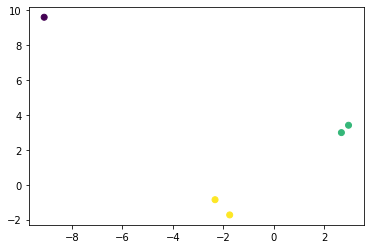

In [ ]:
X = np.array(X)
plt.scatter(X[:,0], X[:,1], c=y)

Text(0, 0.5, 'e')

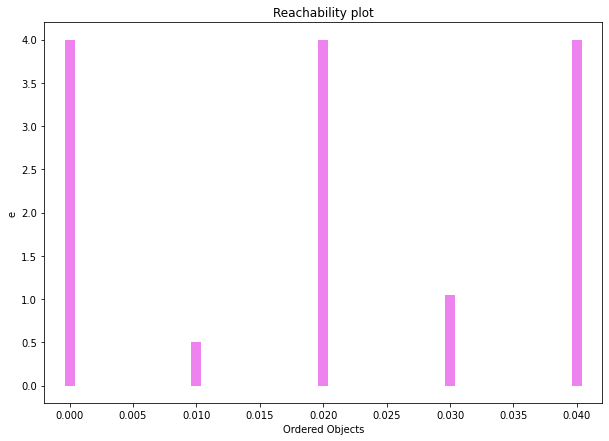

In [ ]:
plt.figure(figsize=(10, 7))
x_coordinate = 0
for i in reachability:
    plt.vlines(x=x_coordinate, ymin=0, ymax=i, colors='violet', lw=10)
    x_coordinate +=0.01

plt.title(f'Reachability plot')
plt.xlabel('Ordered Objects')
plt.ylabel('e')

### Dataset 2

In [ ]:
num_samples_total = 50
cluster_centers = [(3,3), (-2,-1), (-10, 10)]
num_classes = len(cluster_centers)
min_samples = 22
cluster_method = 'xi'
metric = 'minkowski'

# Generate data
X, y = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.5)

num_samples_total = 50
cluster_centers = [(0,2)]
num_classes = len(cluster_centers)
min_samples = 22
cluster_method = 'xi'
metric = 'minkowski'
X_1, y_1 = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 3)


X = np.concatenate((X, X_1), axis=0)

y = np.concatenate((y, y_1), axis=0)

SetOfObjects = []

In [ ]:
for i in X:
    SetOfObjects.append(Object(i))
e = 3
MinPts = 10
OrderedObjs = []
OrderedObjs = OPTICS(SetOfObjects, e, MinPts, OrderedObjs)

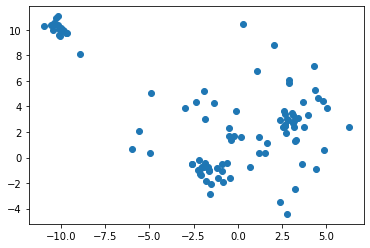

In [ ]:
plt.scatter(X[:,0], X[:,1])

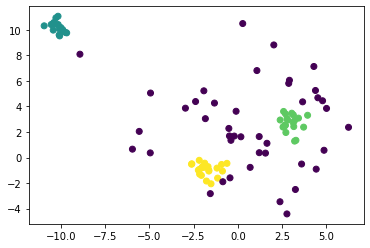

In [ ]:
e_ = 1
OrderedObjs = ExtractDBSCAN_Clustering(OrderedObjs, e_, MinPts)
X = []
y = []
reachability = []
for i in OrderedObjs:
    #print(i.value, i.cluster_id, i.reachability_distance, i.core_distance)
    X.append(i.value)
    y.append(i.cluster_id)
    if i.reachability_distance == np.inf :
        reachability.append(e+1)
    else:
        reachability.append(i.reachability_distance)
X = np.array(X)
plt.scatter(X[:,0], X[:,1], c=y)

Text(0, 0.5, 'e')

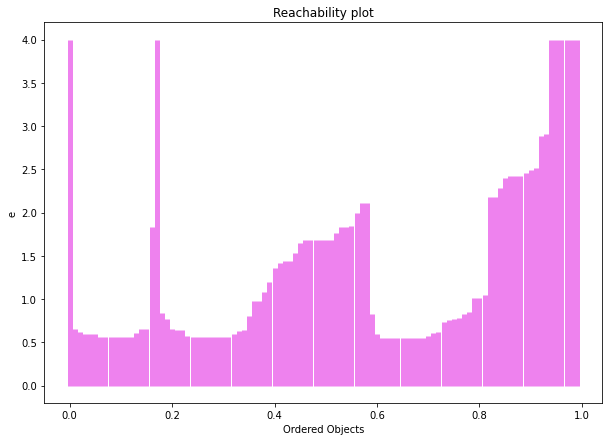

In [ ]:
plt.figure(figsize=(10, 7))
x_coordinate = 0
for i in reachability:
    plt.vlines(x=x_coordinate, ymin=0, ymax=i, colors='violet', lw=5)
    x_coordinate +=0.01

plt.title(f'Reachability plot')
plt.xlabel('Ordered Objects')
plt.ylabel('e')

## Original DBSCAN

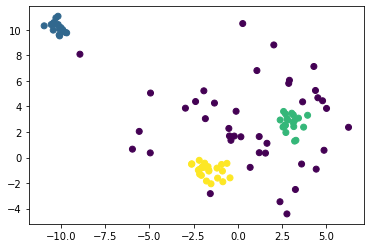

In [ ]:
from sklearn.cluster import DBSCAN
X = np.array(X)
clustering = DBSCAN(eps=1, min_samples=10).fit(X)
plt.scatter(X[:,0], X[:,1], c=clustering.labels_)

## K-means result

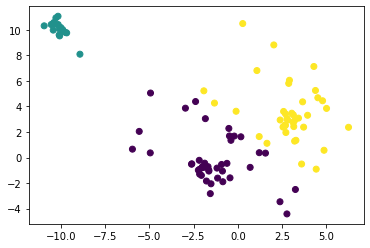

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)